Once the model is trained, use a testset to explain how to apply this model on a new data.

In [ ]:

#install the packages
!pip install numpy==2.0.2 pandas==2.2.3 matplotlib==3.9.2 scikit-learn==1.6.1 tensorflow==2.19.0 joblib==1.4.2


In [ ]:
#upload files
from google.colab import files

uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import os
import joblib

class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)  # Always use dropout for training and prediction

def selective_quantile_loss(tau=0.7, threshold=0.95):
    def loss(y_true, y_pred):
        # Mask: 1 if y_true > threshold (in standard scaled data), else 0
        mask = K.cast(y_true > threshold, dtype='float32')
        
        # Quantile loss (asymmetric) applied only to peaks
        error = y_true - y_pred
        quantile = K.maximum(tau * error, (tau - 1) * error)
        peak_loss = mask * quantile

        # Optional: apply MSE to non-peak values
        mse_loss = (1.0 - mask) * K.square(error)

        return K.mean(peak_loss + mse_loss)
    return loss

# Load Data with Hourly Timestamps
def load_data(file_path, name=None):
    df = pd.read_csv(file_path, usecols=["Timestamp", "Varibale Value"], low_memory=False)

    # Convert timestamp
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %H:%M")
    df = df.sort_values(by='Timestamp') 

    # Ensure variable column is numeric
    df["Varibale Value"] = pd.to_numeric(df["Varibale Value"], errors="coerce")

    # Rename columns for clarity
    if name is not None:
        df = df.rename(columns={"Varibale Value": name})

    return df

def load_GloFAS_data(file_path, name='GloFAS_error_In'):
    df = pd.read_csv(file_path, usecols=["Timestamp", "spread"], low_memory=False)

    # Convert timestamp
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %H:%M")
    df = df.sort_values(by='Timestamp') 

    # Ensure variable column is numeric
    df["spread"] = pd.to_numeric(df["spread"], errors="coerce")

    # Rename columns for clarity
    if name is not None:
        df = df.rename(columns={"spread": name})

    return df

def data_clean_align_date_3(df1, df2, df3):
    """
    Align df1, df2, and df3 on a common hourly timeline, and fill missing values using ffill, then bfill.
    Assumes all have a 'Timestamp' column (datetime).
    Returns: df1_aligned, df2_aligned, df3_aligned
    """
    # Ensure Timestamp is datetime
    for df in [df1, df2, df3]:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Build full hourly timeline from min to max of all dfs
    start = max(df1['Timestamp'].min(), df2['Timestamp'].min(), df3['Timestamp'].min())
    end   = min(df1['Timestamp'].max(), df2['Timestamp'].max(), df3['Timestamp'].max())
    full_timeline = pd.DataFrame({'Timestamp': pd.date_range(start=start, end=end, freq='H')})

    # Merge to align each df on the hourly timeline
    df1_aligned = pd.merge(full_timeline, df1, on='Timestamp', how='left')
    df2_aligned = pd.merge(full_timeline, df2, on='Timestamp', how='left')
    df3_aligned = pd.merge(full_timeline, df3, on='Timestamp', how='left')

    # Fill missing values: forward fill, then backward fill for leading NaNs
    df1_aligned = df1_aligned.ffill().bfill()
    df2_aligned = df2_aligned.ffill().bfill()
    df3_aligned = df3_aligned.ffill().bfill()

    return df1_aligned, df2_aligned, df3_aligned

# Aggregate hourly data into assigned time step, for target column and input column
def aggregate_to_nhourly_last_timestamp(df, aggregation_period=3):
    # Sort and reset index
    df = df.sort_values(by='Timestamp').reset_index(drop=True)

    # Group by the specified aggregation period
    group_size = aggregation_period
    num_groups = len(df) // group_size

    result = []
    for i in range(num_groups):
        group = df.iloc[i*group_size : (i+1)*group_size]
        avg_1 = group.iloc[:, 1].mean()  # First value column
        timestamp = group.iloc[-1]["Timestamp"]  # Use last timestamp in the group
        result.append({
            "Timestamp": timestamp,
            df.columns[1]: avg_1,
        })

    return pd.DataFrame(result)

# Merge Two DataFrames with lagged time step 
def merge_with_context_lag(
    df_target, df_context, lag_steps=7, 
    target_col='419012_target', context_col='419001_context', lagged_col = "419001_context_lag"):
    # Ensure sorted by timestamp
    df_target = df_target.sort_values('Timestamp').reset_index(drop=True)
    df_context = df_context.sort_values('Timestamp').reset_index(drop=True)
    
    # Create dummy (lagged context)
    dummy = df_context[['Timestamp']].copy()
    dummy[lagged_col] = df_context[context_col].shift(lag_steps)
    dummy = dummy.dropna(subset=[lagged_col]).reset_index(drop=True)
    
    # Merge all on Timestamp (only rows present in dummy will be kept)
    merged = (
        df_target
        .merge(df_context, on='Timestamp', how='inner', suffixes=('', '_context'))
        .merge(dummy, on='Timestamp', how='inner')
    )
    
    # Rename columns for clarity if needed
    merged = merged.rename(columns={
        target_col: target_col,
        context_col: context_col,
        lagged_col: lagged_col
    })
    
    return merged

def merge_with_GloFAS(merged_df, df3):
    # Identify non-Timestamp column (optional, for clarity)
    data_col = [col for col in df3.columns if col != 'Timestamp'][0]
    # Merge directly, no renaming
    merged = merged_df.merge(df3, on='Timestamp', how='inner')
    return merged

# include labels (train/vali/test) if any, otherwise it follows the simplest preprocessing
def create_sequences(data, window_size, lead_time, labels=None):
    X, Y, seq_labels = [], [], []
    n = len(data)
    for i in range(n - window_size - lead_time + 1):
        # Check input window and output (target) labels
        if labels is not None:
            input_labels = labels[i : i + window_size]
            output_labels = labels[i + window_size : i + window_size + lead_time]
            all_labels = np.concatenate([input_labels, output_labels])
            if not np.all(all_labels == all_labels[0]):
                continue  # Only keep "pure" sequences
            this_label = all_labels[0]
        else:
            this_label = None

        X.append(data[i:i+window_size])
        Y.append(data[i+window_size:i+window_size+lead_time].flatten())
        if labels is not None:
            seq_labels.append(this_label)

    if labels is not None:
        return np.array(X), np.array(Y), np.array(seq_labels)
    else:
        return np.array(X), np.array(Y)

# Create Input-Output Sequences
def preprocess_data_inference_3col(
    df, scaler, target_column, context_column1, context_column2,
    window_size=48, lead_time=16
):
    """
    Preprocess new data for inference using an existing, already-fitted scaler for 3 columns.
    Returns LSTM-ready X, dummy Y, unscaled targets, unscaled context2, date sequences, and the scaler.
    """
    # Transform with the provided, already-fitted scaler (on all three columns)
    input_features = [target_column, context_column1, context_column2]
    scaled_data = scaler.transform(df[input_features])

    # Create LSTM input sequences using all three features
    X, _ = create_sequences(scaled_data, window_size, lead_time)
    X = X.reshape((X.shape[0], X.shape[1], 3))  # (samples, window_size, 3 features)

    # Dummy Y (all zeros, for inference; shape matches (samples, lead_time))
    Y = np.zeros((X.shape[0], lead_time))

    # Unscaled target (raw values) from target_column
    _, Y_unscaled = create_sequences(df[target_column].values.reshape(-1, 1), window_size, lead_time)

    # Unscaled context2 (Glo_error_unscale)
    _, Glo_error_unscale = create_sequences(df[context_column2].values.reshape(-1, 1), window_size, lead_time)

    # Date sequences
    _, date_sequences = create_sequences(df["Timestamp"].values.reshape(-1, 1), window_size, lead_time)

    return X, Y, Y_unscaled, Glo_error_unscale, date_sequences


def build_lstm_model(window_size, lead_time, dropout_rate=0.05):
    model = Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(window_size, 3)),
        MCDropout(dropout_rate),
        LSTM(100, activation='tanh'),
        MCDropout(dropout_rate),
        Dense(lead_time)
    ])
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=selective_quantile_loss(tau=0.7, threshold=0.95))
    return model

# Forecasting
def forecast_mc_dropout(model, X_test, scaler, Glofas_raw_y_error, T=100):
    """
    MC Dropout forecast with correct inverse scaling for a scaler fit on 2 columns.
    Args:
        model: Trained Keras model with MCDropout layers.
        X_test: Test input, shape (samples, timesteps, features).
        scaler: Scaler fit on 2 columns (the first is the target).
        T: Number of MC samples.
    Returns:
        mean_prediction, std_prediction: Both are (samples, n_steps) arrays in original scale.
    """
    preds_scaled = []

    for _ in range(T):
        # MC Dropout prediction (dropout ON at test time)
        pred = model(X_test, training=True).numpy()  # shape: (samples, n_steps)
        preds_scaled.append(pred)
    preds_scaled = np.array(preds_scaled)  # shape: (T, samples, n_steps)

    # Compute mean and std along the MC sample axis (axis=0)
    mean_scaled = np.mean(preds_scaled, axis=0)   # shape: (samples, n_steps)
    std_scaled = np.std(preds_scaled, axis=0)     # shape: (samples, n_steps)

    # Inverse scale, assuming scaler was fit on 3 columns and target is column 0
    def inverse_scale(pred_scaled):
        n_samples, n_steps = pred_scaled.shape
        dummy_input = np.zeros((n_samples * n_steps, 3))
        dummy_input[:, 0] = pred_scaled.flatten()
        pred_inverse = scaler.inverse_transform(dummy_input)[:, 0]
        return pred_inverse.reshape(n_samples, n_steps)

    mean_prediction = inverse_scale(mean_scaled)
    # For std: only multiply by the target column's std scale (no shift for std)
    std_scale = scaler.scale_[0]
    std_prediction = std_scaled * std_scale

    # Add GloFAS error to the mean prediction if provided
    std_prediction_all = std_prediction + Glofas_raw_y_error

    return mean_prediction, std_prediction_all

# Evaluation Metrics
def calculate_nse(actual, predicted):
    return 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

def calculate_kge(actual, predicted):
    r = np.corrcoef(actual.squeeze(), predicted.squeeze())[0, 1]
    beta = np.mean(predicted) / np.mean(actual)
    gamma = np.std(predicted) / np.std(actual)
    return 1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2)

def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Plot Results
def plot_results_with_uncertainty(actual, predicted, uncertainty, dates, lead_step=-1, save_path=None):
    """
    Plot for a chosen lead step (default: last lead step).
    """
    import numpy as np
    # allow users to choose lead step (1-based, if negative, use last)
    if lead_step < 0:
        lead_index = actual.shape[1] - 1
    else:
        lead_index = lead_step if lead_step < actual.shape[1] else actual.shape[1] - 1
    actual_plot = actual[:, lead_index]
    predicted_plot = predicted[:, lead_index]
    uncertainty_plot = uncertainty[:, lead_index]
    dates_plot = dates[:, lead_index]

    rmse      = root_mean_squared_error(actual_plot, predicted_plot)
    nse_value = calculate_nse(actual_plot, predicted_plot)
    kge_value = calculate_kge(actual_plot, predicted_plot)

    plt.style.use('ggplot')
    plt.rcParams.update({
        'font.family':        'sans-serif',
        'font.sans-serif':    ['Arial'],
        'font.size':         14,
        'axes.titlesize':    18,
        'axes.labelsize':    16,
        'xtick.labelsize':   14,
        'ytick.labelsize':   14,
        'legend.fontsize':   18,
        'figure.titlesize':  20
    })

    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('none')    
    ax.set_facecolor('none') 
    ax.grid(False)

    lower = predicted_plot - 1.96 * uncertainty_plot
    upper = predicted_plot + 1.96 * uncertainty_plot
    lower = np.where(lower < 0, 1, lower)

    ax.plot(dates_plot, actual_plot, label='Actual Flow Rate (ML/day)', linewidth=2)
    ax.plot(dates_plot, predicted_plot, label='Predicted Flow Rate (ML/day)', linestyle='--', linewidth=2)
    ax.fill_between(dates_plot, lower, upper, color='gray', alpha=0.3, label="95% Prediction Interval")
    ax.set_title(f"Lead: {lead_index+1} | RMSE: {rmse:.1f}, NSE: {nse_value:.2f}, KGE: {kge_value:.2f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Flow Rate (ML/day)")
    ax.legend()
    fig.autofmt_xdate(rotation=45, ha='right')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    plt.close(fig)

def save_results_excel_per_lead_with_uncertainty(actual, predicted, uncertainty, dates, save_path="prediction_results_by_lead.xlsx"):
    """
    Save results for each lead time to a separate sheet in an Excel file.
    Each sheet has columns: Timestamp, Actual_FlowRate, Predicted_FlowRate, Uncertainty
    """
    import openpyxl
    n_samples, n_leads = actual.shape
    with pd.ExcelWriter(save_path, engine="openpyxl") as writer:
        for lead in range(n_leads):
            df_lead = pd.DataFrame({
                "Timestamp": pd.to_datetime(dates[:, lead]),
                "Actual_FlowRate": actual[:, lead],
                "Predicted_FlowRate": predicted[:, lead],
                "Uncertainty": uncertainty[:, lead]
            })
            df_lead.to_excel(writer, sheet_name=f"Lead_{lead+1}", index=False)




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os

# Make sure you have already defined:
#   load_data
#   create_sequences
#   build_lstm_model
#   forecast
#   preprocess_data_inference (as above)

if __name__ == "__main__":
    # File paths for the two locations
    file1 = './test_419012.csv'  # Boggabri  (target)
    file2 = './test_419001.csv'  # Gunnedah (context)
    file3 = './test_GloFAS_spread_419012.csv'  # GloFAS error

    # Rename the columns for clarity
    name1 = "419012_target"
    name2 = "419001_context"
    name3 = "419001_context_lag"
    name4 = "GloFAS_error_In"
    
    # Set parameters
    window_size = 48 # Change as needed
    lead_time = 16  # Change as needed
    timescale = 3
    lag_steps = 5  # Number of steps to lag context column

    # -----1.Load and merge the datasets------
    df1 = load_data(file1,name1)
    df2 = load_data(file2,name2)
    df3 = load_GloFAS_data(file3, name4)
    df1,df2,df3 = data_clean_align_date_3(df1,df2,df3)

    # Aggregate into 3 hourly
    df1 = aggregate_to_nhourly_last_timestamp(df1, timescale)
    df2 = aggregate_to_nhourly_last_timestamp(df2, timescale)
    df3 = aggregate_to_nhourly_last_timestamp(df3, timescale)

    #Merge with lagged contex
    df = merge_with_context_lag(df1, df2, lag_steps, 
                                 target_col= name1, context_col=name2,lagged_col=name3)
    df = merge_with_GloFAS(df, df3)

    #Cut df to ensure floods event in all three periods
    start_date = pd.to_datetime("2022-07-01")
    end_date = pd.to_datetime("2023-01-31")
    df = df[(df['Timestamp'] >= start_date) & (df['Timestamp'] <= end_date)]

    # --- 2. Load the saved scaler ---
    model_path = "lstm_flood_pro10_model3.h5"
    weights_path = model_path + "_best_val.weights.h5"
    scaler_path = model_path.replace('.h5', '_scaler.pkl')

    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"Cannot find scaler file: {scaler_path}")
    scaler = joblib.load(scaler_path)

    # --- 3. Preprocess new data (use inference version) ---
    X_new, Y_new_scaled, Y_new_unscaled, Glofas_new_raw_y_error, new_dates = preprocess_data_inference_3col(
        df = df,
        scaler = scaler,
        target_column = name1,
        context_column1= name3,
        context_column2= name4,  # GloFAS error
        window_size=window_size,
        lead_time=lead_time
    )

    # --- 4. Build model architecture (must match trained model) ---
    model = build_lstm_model(window_size=window_size, lead_time=lead_time)

    # --- 5. Load trained weights ---
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Cannot find weights file: {weights_path}")
    model.load_weights(weights_path)

    # --- 6. Make predictions ---
    Y_new_prediction_mean, Y_new_prediction_std = forecast_mc_dropout(model, X_new, scaler,Glofas_new_raw_y_error)

    # --- 7. Plot and save results for a selected lead time (e.g., lead 5) ---
    plot_results_with_uncertainty(
        actual = Y_new_unscaled,
        predicted = Y_new_prediction_mean,
        uncertainty = Y_new_prediction_std,
        dates = new_dates,
        leadsteps = 5,  # change this to plot a different lead step (1-based)
        save_path = "uncertainty_vs_actual_lead5.png"
    )

    # --- 8. Save all lead times to an Excel file with uncertainty ---
    save_results_excel_per_lead_with_uncertainty(
        actual = Y_new_unscaled,
        predicted = Y_new_prediction_mean,
        uncertainty = Y_new_prediction_std,
        dates = new_dates,
        save_path = "prediction_results_by_lead_with_uncertainty.xlsx"
    )

C:\Users\z5318148\AppData\Local\Temp\ipykernel_14036\3944940986.py:81: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_timeline = pd.DataFrame({'Timestamp': pd.date_range(start=start, end=end, freq='H')})


Below is model assessment. It produces three heatmaps, providing summary of the forecasts for six flood events (columns, ordered by peak size) and 16 lead steps (rows).

In [6]:
import pandas as pd
import numpy as np

def find_stable_baseflow(flow_series, threshold_time,
                         baseflow_center=1200, delta=200, min_stable_steps=3):
    """
    Find the start of the last stable baseflow window before threshold exceedance.

    Parameters:
        flow_series (pd.Series): Full time-indexed flow series.
        threshold_time (Timestamp): Time when flow first exceeds flood threshold.
        baseflow_center (float): Typical baseflow value (e.g., 1200 ML).
        delta (float): Allowed deviation from baseflow (e.g., ±200 ML).
        min_stable_steps (int): Required number of consecutive low-flow steps.

    Returns:
        Timestamp or pd.NaT
    """
    pre_flood = flow_series[:threshold_time]
    in_range = pre_flood.between(baseflow_center - delta, baseflow_center + delta)

    count = 0
    for i in range(len(in_range) - 1, -1, -1):
        if in_range.iloc[i]:
            count += 1
            if count >= min_stable_steps:
                return in_range.index[i]
        else:
            count = 0

    return pd.NaT


def identify_flood_events(flow_series, threshold=47500, baseflow_center=1200,
                          delta=200, min_stable_steps=3, min_duration=3):
    """
    Identify flood events and compute time to exceed flood threshold from stable baseflow.

    Parameters:
        flow_series (pd.Series): Time-indexed flow data.
        threshold (float): Flood threshold to define events (default: 47500 ML).
        baseflow_center (float): Typical baseflow level (default: 1200 ML).
        delta (float): Allowed deviation for baseflow stability (default: ±200 ML).
        min_stable_steps (int): Minimum number of stable baseflow steps.
        min_duration (int): Minimum event duration in steps.

    Returns:
        List of dicts with event details and time to exceed from baseflow.
    """
    above_thresh = flow_series > threshold
    event_mask = above_thresh.astype(int)

    events = []
    in_event = False
    start_idx = None

    for i in range(len(event_mask)):
        if event_mask.iloc[i] == 1 and not in_event:
            start_idx = i
            in_event = True
        elif event_mask.iloc[i] == 0 and in_event:
            end_idx = i
            if (end_idx - start_idx) >= min_duration:
                event_flow = flow_series.iloc[start_idx:end_idx]
                peak_idx = event_flow.idxmax()

                exceed_candidates = event_flow[event_flow > threshold]
                if exceed_candidates.empty:
                    continue  # skip this event if no valid exceedance found
                exceed_time = exceed_candidates.index[0]

                baseflow_time = find_stable_baseflow(
                    flow_series,
                    threshold_time=exceed_time,
                    baseflow_center=baseflow_center,
                    delta=delta,
                    min_stable_steps=min_stable_steps
                )

                if pd.notna(baseflow_time):
                    time_to_exceed = (exceed_time - baseflow_time).total_seconds() / 3600
                else:
                    time_to_exceed = np.nan

                events.append({
                    "start_time": event_flow.index[0],
                    "end_time": event_flow.index[-1],
                    "peak_time": peak_idx,
                    "peak_value": event_flow.max(),
                    "duration": len(event_flow),
                    "first_exceed_time": exceed_time,
                    "baseflow_time": baseflow_time,
                    "time_to_exceed_from_baseflow": time_to_exceed
                })
            in_event = False

    return events

def build_bias_matrices_ascending(
    actual_series_by_lead, predictions_by_lead, prediction_times_by_lead, identify_flood_events, threshold=47500
):
    """
    Build peak value and timing bias matrices across lead times by comparing
    predicted flood events to actual ones at each lead, with events sorted
    from smallest to largest by peak value (ascending order).

    Parameters:
        actual_series_by_lead (list of 1D arrays): Actual values for each lead time.
        predictions_by_lead (list of 1D arrays): Predicted values for each lead time.
        prediction_times_by_lead (list of 1D arrays): Corresponding datetime arrays for each lead.
        identify_flood_events (function): Function to extract events from a pd.Series.
        threshold (float): Threshold value to compute first exceedance bias (default=47500).

    Returns:
        bias_value_matrix (np.ndarray): Bias in peak value [lead, event]
        bias_time_matrix (np.ndarray): Bias in peak timing [lead, event]
        bias_time_exceed_minor (np.ndarray): Bias in time to first threshold exceedance [lead, event]
        sorted_actual_events (list): Flood events (ascending by peak) used for x-axis
    """
    import numpy as np
    import pandas as pd

    num_leads = len(predictions_by_lead)

    # Use final lead for consistent actual event ordering
    final_actual_series = pd.Series(
        actual_series_by_lead[-1], index=pd.to_datetime(prediction_times_by_lead[-1])
    )
    sorted_actual_events = identify_flood_events(final_actual_series)
    sorted_actual_events = sorted(sorted_actual_events, key=lambda e: e['peak_value'])
    n_events = len(sorted_actual_events)

    bias_value = np.full((num_leads, n_events), np.nan)
    bias_time = np.full((num_leads, n_events), np.nan)
    bias_time_exceed_minor = np.full((num_leads, n_events), np.nan)  # New matrix

    for lead in range(num_leads):
        actual_series = pd.Series(
            actual_series_by_lead[lead],
            index=pd.to_datetime(prediction_times_by_lead[lead])
        )
        pred_series = pd.Series(
            predictions_by_lead[lead],
            index=pd.to_datetime(prediction_times_by_lead[lead])
        )

        actual_events = identify_flood_events(actual_series)
        pred_events = identify_flood_events(pred_series)

        for pred_event in pred_events:
            pred_peak_time = pred_event['peak_time']
            pred_peak_value = pred_event['peak_value']

            if not actual_events:
                continue

            closest_actual = min(
                actual_events,
                key=lambda act: abs((act['peak_time'] - pred_peak_time).total_seconds())
            )

            try:
                event_index = sorted_actual_events.index(closest_actual)
            except ValueError:
                continue

            actual_peak_time = closest_actual['peak_time']
            actual_peak_value = closest_actual['peak_value']

            bias_value[lead, event_index] = pred_peak_value - actual_peak_value
            bias_time[lead, event_index] = (pred_peak_time - actual_peak_time).total_seconds() / 3600

            # ---- Exceedance timing bias ----
            # Actual: when does it first reach/exceed threshold *for this event*?
            actual_event_window = actual_series.loc[closest_actual['start_time']:closest_actual['end_time']]
            pred_event_window = pred_series.loc[pred_event['start_time']:pred_event['end_time']]
            try:
                actual_time_cross = actual_event_window[actual_event_window >= threshold].index[0]
                pred_time_cross = pred_event_window[pred_event_window >= threshold].index[0]
                bias_time_exceed_minor[lead, event_index] = (pred_time_cross - actual_time_cross).total_seconds() / 3600
            except IndexError:
                # Could not find threshold crossing in this event window
                continue

    return bias_value, bias_time, bias_time_exceed_minor, sorted_actual_events



def plot_bias_heatmap(
    bias_matrix, title, value_bias=True, vmin=None, vmax=None, lead_time_freq=3
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    plt.figure(figsize=(6, 6))

    # Use Arial font
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    cmap = "RdBu_r" if value_bias else "RdYlGn_r"

    # Calculate y-tick labels based on lead_time_freq
    n_leads = bias_matrix.shape[0]
    yticklabels = np.arange(0, n_leads * lead_time_freq, lead_time_freq)

    ax = sns.heatmap(
        bias_matrix,
        cmap=cmap,
        xticklabels=False,
        yticklabels=yticklabels,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={"shrink": 0.85},  # Keep bar, no label
        linewidths=0.4,
        linecolor='white',
        square=False
    )

    ax.set_title(title, fontweight='bold', pad=10)
    ax.set_xlabel("Flood Events (increasing peak value)", labelpad=10)
    ax.set_ylabel(f"Lead Time (hour)", labelpad=10)

    # Remove colorbar label
    cbar = ax.collections[0].colorbar
    cbar.set_label("")  # Just blank out the label

    plt.tight_layout()
    plt.show()


def plot_skill_by_lead(
    actual_series_by_lead, predictions_by_lead, prediction_times_by_lead,
    calculate_nse, calculate_kge, root_mean_squared_error,
    nse_ylim_min=0.6, nse_ylim_max=1.0,
    lead_time_freq=3  # new argument for lead time frequency
):
    n_leads = len(actual_series_by_lead)
    nse_list = []
    rmse_list = []

    for lead in range(n_leads):
        actual = np.array(actual_series_by_lead[lead])
        predicted = np.array(predictions_by_lead[lead])
        mask = ~np.isnan(actual) & ~np.isnan(predicted)
        actual_valid = actual[mask]
        predicted_valid = predicted[mask]
        nse = calculate_nse(actual_valid, predicted_valid)
        rmse = root_mean_squared_error(actual_valid, predicted_valid)
        nse_list.append(nse)
        rmse_list.append(rmse)

    leads = np.arange(n_leads)
    lead_times = leads * lead_time_freq  # x-tick values in hours

    plt.style.use('ggplot')
    fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='none')

    ax1.grid(False)

    # Y1: NSE only
    l1, = ax1.plot(lead_times, nse_list, marker='o', label='NSE', color='tab:blue', linewidth=3, markersize=10)
    ax1.set_xlabel('Lead Time (hour)', fontsize=22)
    ax1.set_ylabel('NSE', fontsize=22)
    ax1.set_ylim(nse_ylim_min, nse_ylim_max)
    ax1.set_facecolor('none')

    # Set x-ticks to be the lead times
    ax1.set_xticks(lead_times)
    ax1.set_xticklabels([f"{int(lt)}" for lt in lead_times])

    # Make x-ticks and y-ticks larger
    ax1.tick_params(axis='x', labelsize=22)
    ax1.tick_params(axis='y', labelsize=18)

    # Y2: RMSE
    ax2 = ax1.twinx()
    l2, = ax2.plot(lead_times, rmse_list, marker='^', label='RMSE', color='mediumpurple', linewidth=3, markersize=10)
    ax2.set_ylabel('RMSE (ML/day)', fontsize=22)
    ax2.set_facecolor('none')
    ax2.tick_params(axis='y', labelsize=18)

    # Remove axis spines
    for spine in ax1.spines.values():
        spine.set_visible(False)
    for spine in ax2.spines.values():
        spine.set_visible(False)

    # Single legend for both NSE and RMSE
    handles = [l1, l2]
    labels = [h.get_label() for h in handles]
    legend = ax1.legend(handles, labels, loc='upper left', fontsize=20, frameon=False)
    legend.set_title(None)

    plt.tight_layout()
    plt.show()









In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ---- Prepare Input ----
actual_series_by_lead = [Y_new_unscaled[:, i] for i in range(16)]
predictions_by_lead = [Y_new_prediction_mean[:, i] for i in range(16)]
prediction_times_by_lead = [new_dates[:, i] for i in range(16)]

# ---- Build Bias Matrices (ascending peak order) ----
bias_value, bias_time, bias_time_exceed_minor, sorted_actual_events = build_bias_matrices_ascending(
    actual_series_by_lead,
    predictions_by_lead,
    prediction_times_by_lead,
    identify_flood_events,   # your flood event extractor function
    threshold=47500
)


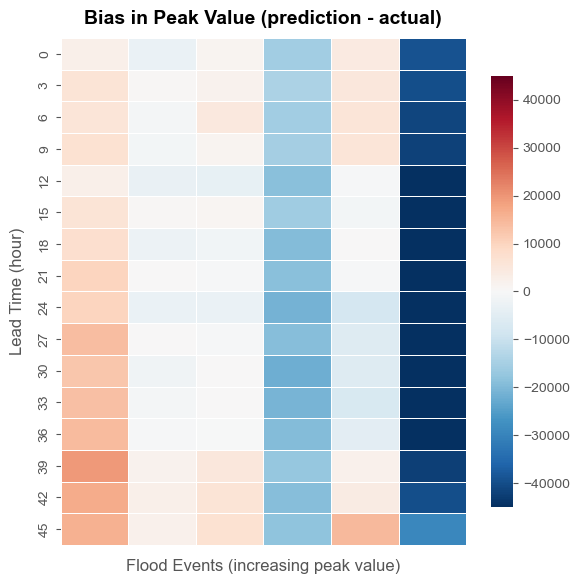

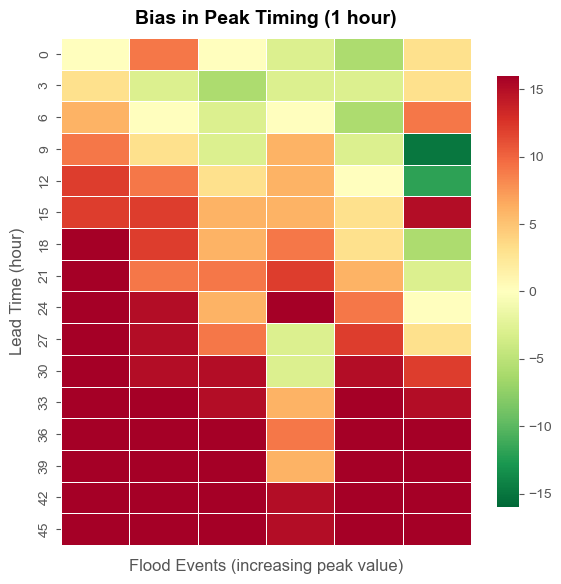

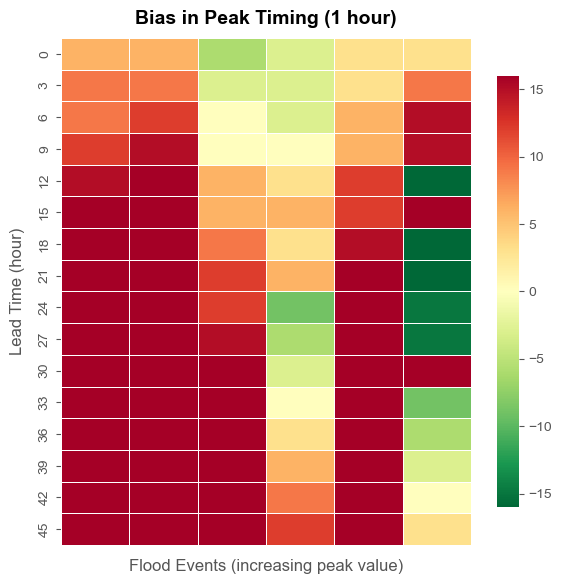

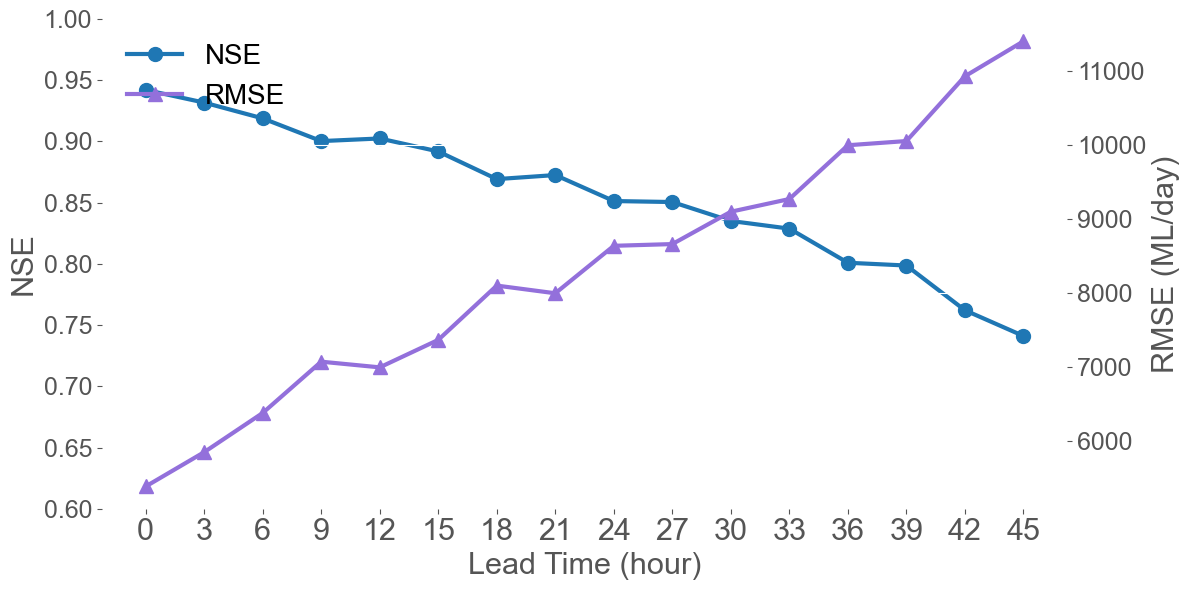

In [8]:

# ---- Plot Results ----
# Bias in flood peak value (Predicted - Actual)
plot_bias_heatmap(
    bias_value,
    title="Bias in Peak Value (prediction - actual)",
    value_bias=True,  # RdBu_r
    vmin=-45000,
    vmax=45000,
    lead_time_freq=3  # Assuming 3-hourly leads
)

# Bias in peak timing (hours)
plot_bias_heatmap(
    bias_time,
    title="Bias in Peak Timing (1 hour)",
    value_bias=False,  # RdYlGn_r
    vmin=-16,
    vmax=16
)

# ---- Plot Bias in Threshold Exceedance Timing ----
plot_bias_heatmap(
    bias_time_exceed_minor,
    title="Bias in Peak Timing (1 hour)",
    value_bias=False,  # RdYlGn_r
    vmin=-16,
    vmax=16
)

# ---- Plot Skill Scores by Lead Time ----
plot_skill_by_lead(
    actual_series_by_lead,
    predictions_by_lead,
    prediction_times_by_lead,
    calculate_nse,
    calculate_kge,
    root_mean_squared_error,
    nse_ylim_min=0.6,
    nse_ylim_max=1.0,
    lead_time_freq=3  # Adjusted for better visibility
)

